# Robust Linear Models

In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

## Estimation

Load data:

In [2]:
data = sm.datasets.stackloss.load()
data.exog = sm.add_constant(data.exog)

Huber's T norm with the (default) median absolute deviation scaling

In [4]:
huber_t = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(hub_results.params)
print(hub_results.bse)
print(hub_results.summary(yname='y',
            xname=['var_%d' % i for i in range(len(hub_results.params))]))

[-41.02649835   0.82938433   0.92606597  -0.12784672]
[9.79189854 0.11100521 0.30293016 0.12864961]
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 05 Jan 2022                                         
Time:                        23:50:31                                         
No. Iterations:                    19                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

Huber's T norm with 'H2' covariance matrix

In [5]:
hub_results2 = huber_t.fit(cov="H2")
print(hub_results2.params)
print(hub_results2.bse)

[-41.02649835   0.82938433   0.92606597  -0.12784672]
[9.08950419 0.11945975 0.32235497 0.11796313]


Andrew's Wave norm with Huber's Proposal 2 scaling and 'H3' covariance matrix

In [6]:
andrew_mod = sm.RLM(data.endog, data.exog, M=sm.robust.norms.AndrewWave())
andrew_results = andrew_mod.fit(scale_est=sm.robust.scale.HuberScale(), cov="H3")
print ('Parameters: ', andrew_results.params)

Parameters:  [-40.8817957    0.79276138   1.04857556  -0.13360865]


See ``help(sm.RLM.fit)`` for more options and ``module sm.robust.scale`` for scale options

## Comparing OLS and RLM

Artificial data with outliers:

In [7]:
nsample = 50
x1 = np.linspace(0, 20, nsample)
X = np.column_stack((x1, (x1-5)**2))
X = sm.add_constant(X)
sig = 0.3   # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta)
y2 = y_true2 + sig*1. * np.random.normal(size=nsample)
y2[[39,41,43,45,48]] -= 5   # add some outliers (10% of nsample)

### Example 1: quadratic function with linear truth

Note that the quadratic term in OLS regression will capture outlier effects. 

In [10]:
res = sm.OLS(y2, X).fit()
print(res.params)
print(res.bse)
print(res.predict())

[ 4.9693813   0.5353466  -0.01380338]
[0.48279964 0.07453775 0.00659544]
[ 4.6242967   4.89684625  5.16479659  5.42814772  5.68689964  5.94105235
  6.19060584  6.43556012  6.67591519  6.91167105  7.1428277   7.36938514
  7.59134336  7.80870237  8.02146217  8.22962276  8.43318414  8.63214631
  8.82650926  9.016273    9.20143753  9.38200285  9.55796896  9.72933585
  9.89610354 10.05827201 10.21584127 10.36881132 10.51718215 10.66095378
 10.80012619 10.93469939 11.06467338 11.19004816 11.31082373 11.42700008
 11.53857722 11.64555515 11.74793387 11.84571338 11.93889368 12.02747476
 12.11145663 12.19083929 12.26562274 12.33580698 12.40139201 12.46237782
 12.51876442 12.57055181]


Estimate RLM:

In [11]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)
print(resrlm.bse)

[ 4.91114601e+00  5.18777057e-01 -2.36026629e-03]
[0.13789115 0.02128853 0.00188371]


Draw a plot to compare OLS estimates to the robust estimates:

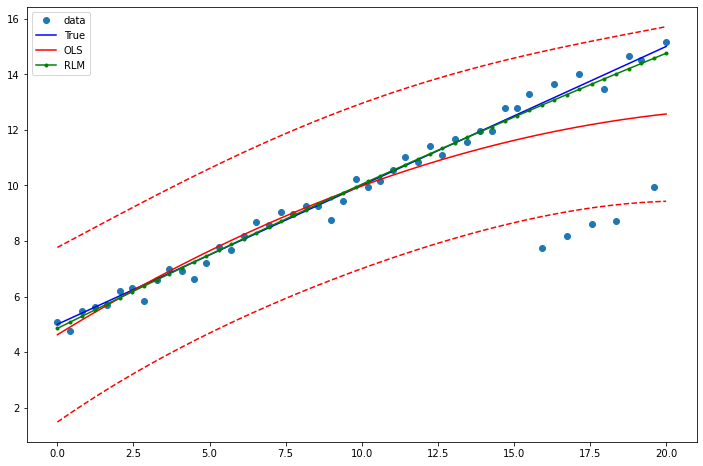

In [12]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, 'o',label="data")
ax.plot(x1, y_true2, 'b-', label="True")
prstd, iv_l, iv_u = wls_prediction_std(res)
ax.plot(x1, res.fittedvalues, 'r-', label="OLS")
ax.plot(x1, iv_u, 'r--')
ax.plot(x1, iv_l, 'r--')
ax.plot(x1, resrlm.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")

### Example 2: linear function with linear truth

Fit a new OLS model using only the linear term and the constant:

In [13]:
X2 = X[:,[0,1]] 
res2 = sm.OLS(y2, X2).fit()
print(res2.params)
print(res2.bse)

[5.5257422  0.39731276]
[0.4169703  0.03592785]


Estimate RLM:

In [14]:
resrlm2 = sm.RLM(y2, X2).fit()
print(resrlm2.params)
print(resrlm2.bse)

[4.99404782 0.4985788 ]
[0.11163731 0.00961912]


Draw a plot to compare OLS estimates to the robust estimates:

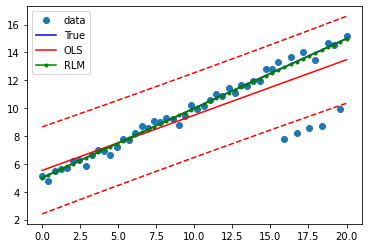

In [15]:
prstd, iv_l, iv_u = wls_prediction_std(res2)

fig, ax = plt.subplots()
ax.plot(x1, y2, 'o', label="data")
ax.plot(x1, y_true2, 'b-', label="True")
ax.plot(x1, res2.fittedvalues, 'r-', label="OLS")
ax.plot(x1, iv_u, 'r--')
ax.plot(x1, iv_l, 'r--')
ax.plot(x1, resrlm2.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")